In [46]:
from lammps import lammps
import numpy as np
lmp = lammps()
lmp.file("run-modernreax-lammps.sh") # Fluorite CeO2 from https://next-gen.materialsproject.org/materials/mp-20194?chemsys=Ce-O

LAMMPS (2 Aug 2023 - Update 3)
Total wall time: 0:01:39
Reading data file ...
  orthogonal box = (0 0 0) to (5.46745 5.46745 5.46745)
  1 by 1 by 1 MPI processor grid
  reading atoms ...
  12 atoms
  read_data CPU = 0.000 seconds

CITE-CITE-CITE-CITE-CITE-CITE-CITE-CITE-CITE-CITE-CITE-CITE-CITE

Your simulation uses code contributions which should be cited:
- pair reaxff command: doi:10.1016/j.parco.2011.08.005
- fix qeq/reaxff command: doi:10.1016/j.parco.2011.08.005
The log file lists these citations in BibTeX format.

CITE-CITE-CITE-CITE-CITE-CITE-CITE-CITE-CITE-CITE-CITE-CITE-CITE

Switching to 'neigh_modify every 1 delay 0 check yes' setting during minimization
Neighbor list info ...
  update: every = 1 steps, delay = 0 steps, check = yes
  max neighbors/atom: 2000, page size: 100000
  master list distance cutoff = 12
  ghost atom cutoff = 12
  binsize = 6, bins = 1 1 1
  2 neighbor lists, perpetual/occasional/extra = 2 0 0
  (1) pair reaxff, perpetual
      attributes: half, newt

In [47]:
conv = 0.0433641 # eV to kcal/mol
nCeO2 = 32 # Number of CeO2 in the simulation


#Uncomment to see that volume is properly accessed. 
#print(volume)
volume = lmp.get_thermo("vol")
volume_per_CeO2 = volume / nCeO2

#print(lmp.get_thermo("pe"))
E_CeO2 = lmp.get_thermo("pe")* conv / nCeO2
print("Energy per CeO2: ", E_CeO2)


Energy per CeO2:  -1.2241698247360644


In [48]:
#Function to scale data file

import os

def scale_lammps_data(input_file, scale_factor, output_file_dir, output_file_template):
    # Read the input file
    with open(input_file, 'r') as file:
        lines = file.readlines()

    # Find the line indices for box dimensions
    for i, line in enumerate(lines):
        if 'xlo xhi' in line:
            xlo_xhi_index = i
        elif 'ylo yhi' in line:
            ylo_yhi_index = i
        elif 'zlo zhi' in line:
            zlo_zhi_index = i

    # Parse box dimensions
    xlo, xhi = map(float, lines[xlo_xhi_index].split()[:2])
    ylo, yhi = map(float, lines[ylo_yhi_index].split()[:2])
    zlo, zhi = map(float, lines[zlo_zhi_index].split()[:2])

    # Calculate new box dimensions
    new_xhi = xhi * scale_factor
    new_yhi = yhi * scale_factor
    new_zhi = zhi * scale_factor

    # Replace box dimensions in the lines
    lines[xlo_xhi_index] = f"{xlo} {new_xhi} xlo xhi\n"
    lines[ylo_yhi_index] = f"{ylo} {new_yhi} ylo yhi\n"
    lines[zlo_zhi_index] = f"{zlo} {new_zhi} zlo zhi\n"

    # Find the start of the atoms section
    atoms_start = lines.index('Atoms\n') + 2

    # Scale the atom coordinates
    for i in range(atoms_start, len(lines)):
        parts = lines[i].split()
        if len(parts) == 6:
            id, type, charge = parts[:3]
            x, y, z = map(float, parts[3:])

            new_x = x * scale_factor
            new_y = y * scale_factor
            new_z = z * scale_factor

            lines[i] = f"{id} {type} {charge} {new_x} {new_y} {new_z}\n"

    # Determine the output file name
    output_file_name = f"{output_file_template}_{scale_factor:.2f}.CeO2"
    output_file = os.path.join(output_file_dir, output_file_name)

    # Create the output directory if it doesn't exist
    os.makedirs(output_file_dir, exist_ok=True)

    # Write the scaled data to the output file
    with open(output_file, 'w') as file:
        file.writelines(lines)


In [49]:
#Test scaling function
scale_lammps_data("data.CeO2", 2.0, "dataFiles",  "data" )

In [50]:
#Code used to create supercell in cif format.
#Using atomsk one can manually transform the cif file into an lmp file which is saved as
#CeO2_flourite_with_charges.lmp

from ase import Atoms
from ase.build import bulk, make_supercell
from ase.io import write
import numpy as np

# Define lattice parameters for rutile CeO2
a = 5.46745  # Angstrom
c = 5.46745  # Angstrom

# Create the CeO2 unit cell with 12 atoms
fluorite_CeO2 = Atoms(
    symbols='Ce4O8',
    positions=[
        [0.0, 0.0, 0.0],  # Atom positions for Ce (original from the structure i got from MP)
        [0.0, 2.733725, 2.733725],
        [2.733725, 0.0, 2.733725],
        [2.733725, 2.733725, 0.0],
        [1.3668625, 1.3668625, 4.1005875],
        [1.3668625, 4.1005875, 4.1005875],
        [1.3668625, 4.1005875, 1.3668625],
        [1.3668625, 1.3668625, 1.3668625],
        [4.1005875, 1.3668625, 1.3668625],
        [4.1005875, 4.1005875, 1.3668625],
        [4.1005875, 4.1005875, 4.1005875],
        [4.1005875, 1.3668625, 4.1005875],
    ],
    cell=[
        [a, 0, 0],
        [0, a, 0],
        [0, 0, c]
    ],
    pbc=True
)


# Create the supercell of size 2x2x2
fluorite_CeO2_supercell = make_supercell(fluorite_CeO2, [[2,0,0],[0,2,0],[0,0,2]])

# Define the CIF filename or specify your path here if u want this to be organized
cif_filename = "CeO2_fluorite.cif"

# Write the supercell to a CIF file
write(cif_filename, fluorite_CeO2_supercell, format='cif')

In [51]:
#This function adds charges to lmp file created from atomsk. Due to my inability to run atomsk, this will
#not be used. The resulting lmp file has been provided to me by Warisa. (CeO2_flourite_with_charges.lmp)

def add_charges_to_atoms(input_file, output_file):
    # Define the charges for each atom type
    atom_charges = {
        1: 4.0,  # Ce
        2: -2.0  # O
    }

    # Read the file and store its contents
    with open(input_file, "r") as file:
        lines = file.readlines()

    # Find the line number where atom information starts
    atom_info_line = None
    for i, line in enumerate(lines):
        if line.strip().startswith("Atoms"):
            atom_info_line = i + 1
            break

    # If the line number is found, add charges to each atom
    if atom_info_line is not None:
        # Iterate through atom lines and add charges
        for i in range(atom_info_line, len(lines)):
            atom_line = lines[i].split()
            if len(atom_line) < 2:
                continue  # Skip lines that do not have enough elements
            atom_index = atom_line[0]
            atom_type = int(atom_line[1])
            charge = atom_charges.get(atom_type)
            if charge is not None:
                # Modify the line to include charge
                lines[i] = f"         {atom_line[0]}         {atom_line[1]}   {charge}        {atom_line[2]}       {atom_line[3]}       {atom_line[4]}\n"

    # Write the modified contents back to the output file
    with open(output_file, "w") as file:
        file.writelines(lines)

input_file = "CeO2_fluorite.lmp"
output_file = "CeO2_fluorite_with_charges.lmp"
#add_charges_to_atoms(input_file, output_file)

In [52]:
#This function is used to rewrite the run-modernreax-lammps for it to read data from another file.

import re

def replace_and_save(input_filename, string2, output_filename):
    # Read the content from the input file
    with open(input_filename, 'r') as file:
        content = file.read()
    
    # Define the regular expression pattern to find the part after "read_data"
    pattern = r"(read_data\s+)\S+"
    
    # Replace the part after "read_data" with string2
    updated_content = re.sub(pattern, r"\1" + string2, content)
    
    # Write the updated content to the output file
    with open(output_filename, 'w') as file:
        file.write(updated_content)

# Example usage:
#input_filename = "ceo2_reaxff_bulk.lmp"
#string2 = "data.newCeO2"
#output_filename = "ceo2_reaxff_bulk_test.lmp"

# Call the function to test
#replace_and_save(input_filename, string2, output_filename)

In [53]:
# Constants needed for calculations
conv = 0.0433641 # eV to kcal/mol
nCeO2 = 32

start_scale = 0.95
end_scale = 1.25
step = 0.01

size = len(np.arange(start_scale, end_scale, step))


Reading data file ...
  orthogonal box = (0 0 0) to (10.388155 10.388155 10.388155)
  1 by 1 by 1 MPI processor grid
  reading atoms ...
  96 atoms
  read_data CPU = 0.001 seconds
Switching to 'neigh_modify every 1 delay 0 check yes' setting during minimization
Neighbor list info ...
  update: every = 1 steps, delay = 0 steps, check = yes
  max neighbors/atom: 2000, page size: 100000
  master list distance cutoff = 12
  ghost atom cutoff = 12
  binsize = 6, bins = 2 2 2
  2 neighbor lists, perpetual/occasional/extra = 2 0 0
  (1) pair reaxff, perpetual
      attributes: half, newton off, ghost
      pair build: half/bin/newtoff/ghost
      stencil: full/ghost/bin/3d
      bin: standard
  (2) fix qeq/reaxff, perpetual, copy from (1)
      attributes: half, newton off
      pair build: copy
      stencil: none
      bin: none
Setting up cg style minimization ...
  Unit style    : real
  Current step  : 0
Per MPI rank memory allocation (min/avg/max) = 104.6 | 104.6 | 104.6 Mbytes
   Step 

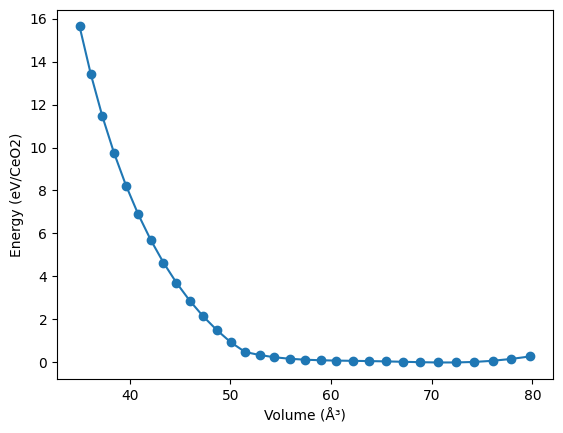

In [54]:
input_file = "data.CeO2"
output_file_dir = "NewAttempt_supercell"
output_file_template = "data"
simulation_file = "run-modernreax-lammps.sh"

volume_array = np.zeros(size)
energy_array = np.zeros(size)
index = 0

for scale_factor in np.arange(start_scale, end_scale, step):
    lmp.command("clear")
    scale_lammps_data("CeO2_flourite_with_charges.lmp", scale_factor, "/Users/andresramos/Desktop/FFparamOpt/NewAttempt_supercell" ,  output_file_template)
    new_Data_file = f'data_{scale_factor:.2f}.CeO2'
    new_simulation_file= f"run-modernreax-lammps{scale_factor:.2f}.sh"
    replace_and_save(simulation_file, new_Data_file, new_simulation_file)
    lmp.file(new_simulation_file)
    volume = lmp.get_thermo("vol")
    volume_per_CeO2 = volume/ nCeO2
    energy_per_CeO2 = lmp.get_thermo("pe")* conv / nCeO2

    volume_array[index] = volume_per_CeO2
    energy_array[index] = energy_per_CeO2
    index +=1

energy_array -= energy_array.min()
import matplotlib.pyplot as plt
plt.plot(volume_array, energy_array, 'o-')
plt.xlabel('Volume (Å³)')
plt.ylabel('Energy (eV/CeO2)')
plt.show()
    